# Extracting and processing STM Image Data from Omicron's propritary .Z_MTRX format 
In order to extract the images, first import the necessary packages. We will be using NanoscoPy to read the STM data and matplotlib to show the data.

In [1]:
import sys
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
# Custom modules
sys.path.append('../../NanoscoPy/')
from nanoscopy import spm
from nanoscopy.utilities import dialog_askdirectory 

### Get Root Folder Path
Prompt the user for the directory which contains the .Z_mtrx files and the result file chain.

In [3]:
folder_path = dialog_askdirectory()

### Read all STM files in the folder

In [4]:
scans = spm.read(folder_path)

Reading 4 sxm files...DONE
Reading 1 mtrx files...DONE


### Inspect some of the data

In [5]:
scans[0].dataframe.head()

,sample_id,probe,channel,direction,trace,setpoint (A),voltage (V),width (m),height (m),scan_time (s),datetime,path,image
0,STM_Au-111_Flat,Au-111,Z,down,forward,1.000000e-09,1.0,4.000000e-08,4.000000e-08,8.533E-1,2021-02-25T11:36:19,G:/Research/AI_STM/NanoscoPy/ExampleDataFiles\...,"[[-1.204225128503822e-07, -1.204216886208087e-..."
1,STM_Au-111_Flat,Au-111,Z,down,backward,1.000000e-09,1.0,4.000000e-08,4.000000e-08,8.533E-1,2021-02-25T11:36:19,G:/Research/AI_STM/NanoscoPy/ExampleDataFiles\...,"[[-1.204103625696007e-07, -1.2040902674925746e..."
2,STM_Au-111_Flat,Au-111,Current,down,forward,1.000000e-09,1.0,4.000000e-08,4.000000e-08,8.533E-1,2021-02-25T11:36:19,G:/Research/AI_STM/NanoscoPy/ExampleDataFiles\...,"[[1.0036380615474627e-09, 9.974532311218809e-1..."
3,STM_Au-111_Flat,Au-111,Current,down,backward,1.000000e-09,1.0,4.000000e-08,4.000000e-08,8.533E-1,2021-02-25T11:36:19,G:/Research/AI_STM/NanoscoPy/ExampleDataFiles\...,"[[1.0091439905934863e-09, 1.007642969064193e-0..."


### Correct the forward sweep data
Each image is globally flattened via plane correction, followed by 2nd order polynomial background subtraction, line-by-line offset flattening, 3x3 gaussian smoothing, and CLAHE.

In [7]:
corrected_scans = spm.correct([spm_data.dataframe.at[0,'image'] for spm_data in scans])

C:\Users\Darian\miniconda3\lib\site-packages\spiepy\flatten.py:54: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m, _, _, _ = np.linalg.lstsq(g, z)


 Corrcting images ####- [ 80.00%] ...DONE


### Show a comparison plot between some of the raw and processed images

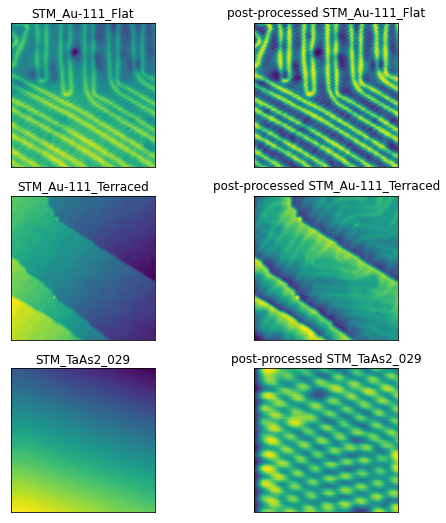

In [8]:
n = 3
fig, axs = plt.subplots(n, 2)
fig.set_figheight(n * 3)
fig.set_figwidth(2 * 4)
for i in range(n):
    raw = scans[i]
    processed = corrected_scans[i]
    sample_name = f'{raw.dataframe["sample_id"].iloc[0]}'

    axs[i, 0].imshow(raw.dataframe['image'].iloc[0] , origin = 'lower')
    axs[i, 0].set_title(sample_name)
    axs[i, 1].imshow(processed , origin = 'lower')
    axs[i, 1].set_title(f'post-processed {sample_name}')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

### Output directories 

In [9]:
dst_paths = [f'{Path(scan.dataframe["path"].iloc[0]).parent}\\{scan.summary()}.jpg' for scan in scans]
dst_paths

['G:\\Research\\AI_STM\\NanoscoPy\\ExampleDataFiles\\STM_Au-111_Flat_210225_1.0V_40x40_Z.jpg',
 'G:\\Research\\AI_STM\\NanoscoPy\\ExampleDataFiles\\STM_Au-111_Terraced_210224_0.5V_44x44_Z.jpg',
 'G:\\Research\\AI_STM\\NanoscoPy\\ExampleDataFiles\\STM_TaAs2_029_190727_1.0V_5x5_Z.jpg',
 'G:\\Research\\AI_STM\\NanoscoPy\\ExampleDataFiles\\STM_WTip_031_210823_1.0V_100x100_Z.jpg',
 'G:\\Research\\AI_STM\\NanoscoPy\\ExampleDataFiles\\WSe2_1_1_210215_-2.4V_5x5_Z.jpg']

### Export the data as jpg

In [ ]:
spm.io.export_spm(corrected_scans, dst_paths)